<a href="https://colab.research.google.com/github/mrudu/farm2plate-api/blob/master/Model_Haryana_JND_Safidon_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.exceptions import UndefinedMetricWarning

import warnings

# Suppress only the specific warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [ ]:
# Read the Yield dataset
file_path = "/content/drive/MyDrive/AlgoLabs/Samunnati/Basmati Project Development/Data/Basmati AYP Haryana.xlsx"
df_yield = pd.read_excel(file_path, sheet_name='Basmati AYP',header=2,usecols="A:D")


# Create a new column 'year_numeric' by extracting the second part after '-'
df_yield['year_numeric'] = df_yield['Year'].str.split('-').str[1].astype(int) + 1999


# Display
print(df_yield)



       Year  Area in lakh  000 Ha  Production in 000 tones  Yield in t/ha  \
0   2009-10                700.00               2656.00000       3.794286   
1   2010-11                781.00               2752.00000       3.523688   
2   2011-12                750.00               2676.00000       3.568000   
3   2012-13                730.00               2261.00000       3.097260   
4   2013-14                710.00               2894.67000       4.077000   
5   2014-15                833.00               3701.85200       4.444000   
6   2015-16                830.00               3231.19000       3.893000   
7   2016-17                720.00               2797.20000       3.885000   
8   2017-18                652.00               2534.97600       3.888000   
9   2018-19                634.00               2137.84800       3.372000   
10  2019-20                843.00               3121.53000       3.702883   
11  2020-21                834.00               3094.14000       3.710000   

In [ ]:
# Set the file path
file_path = '/content/drive/MyDrive/AlgoLabs/Samunnati/Basmati Project Development/Data/Gohana_1985_2024.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Display the first few rows
print(df.head())


     State District   Block       Date  Rainfall  Max_Temperature  \
0  Haryana  Sonipat  Gohana 1985-01-01  0.000000        19.397756   
1  Haryana  Sonipat  Gohana 1985-01-02  0.000000        14.779137   
2  Haryana  Sonipat  Gohana 1985-01-03  0.000000        18.161681   
3  Haryana  Sonipat  Gohana 1985-01-04  0.000000        19.103662   
4  Haryana  Sonipat  Gohana 1985-01-05  0.205186        16.423487   

   Min_Temperature  Relative_Humidity  
0         7.937875          84.062370  
1         5.211319          80.013230  
2         6.073500          70.968155  
3         7.076825          75.785965  
4         8.201275          81.138610  


## Summarising data at the monthly level from the May to October to cover Kharif season

In [ ]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month.apply(lambda x: f"{x:02d}")

# Filter months May to October
df = df[df['month'].isin(['05', '06', '07', '08', '09', '10'])]

# Group by year and month to get:
# - max of Max_Temperature
# - min of Min_Temperature
# - sum of Rainfall
# - mean of Relative Humidity
monthly_summary = df.groupby(['year', 'month']).agg({
    'Max_Temperature': 'max',
    'Min_Temperature': 'min',
    'Rainfall': 'sum',
    'Relative_Humidity': 'mean'
}).reset_index()

# Pivot to wide format
tmax_wide = monthly_summary.pivot(index='year', columns='month', values='Max_Temperature').add_prefix('tmax_')
tmin_wide = monthly_summary.pivot(index='year', columns='month', values='Min_Temperature').add_prefix('tmin_')
rain_wide = monthly_summary.pivot(index='year', columns='month', values='Rainfall').add_prefix('rain_')
rh_wide = monthly_summary.pivot(index='year', columns='month', values='Relative_Humidity').add_prefix('rh_')
# Combine into one DataFrame
annual_weather = pd.concat([tmax_wide, tmin_wide, rain_wide,rh_wide], axis=1).reset_index()

# View the result
print(annual_weather.head())


month  year    tmax_05    tmax_06    tmax_07    tmax_08    tmax_09    tmax_10  \
0      1985  43.843474  42.853313  41.180575  35.946082  36.235994  35.412132   
1      1986  41.675088  44.235288  37.508862  37.993031  37.790663  34.176394   
2      1987  41.803181  44.238937  42.365244  40.478938  38.070712  37.458694   
3      1988  45.738481  43.705737  36.090080  35.234981  37.485843  34.724025   
4      1989  43.235920  41.607138  39.670881  36.570825  36.443100  35.847163   

month    tmin_05    tmin_06    tmin_07  ...     rain_07     rain_08  \
0      21.054987  22.337262  22.842037  ...  226.233900   87.439452   
1      17.935924  20.735131  21.976175  ...   78.281445  106.880819   
2      16.109463  22.815081  24.881581  ...   29.061480  113.789645   
3      22.170600  23.566087  23.644750  ...  302.866498  239.273995   
4      18.368481  22.762563  23.780919  ...   71.497379  171.274554   

month     rain_09    rain_10      rh_05      rh_06      rh_07      rh_08  \
0       38

In [ ]:
# output_path = "/content/drive/MyDrive/AlgoLabs/Samunnati/Basmati Project Development/Data/Gohana_weather_annual_data.xlsx"

# # Save to Excel
# annual_weather.to_excel(output_path, index=False)

# print(f"✅ File saved successfully at: {output_path}")

✅ File saved successfully at: /content/drive/MyDrive/AlgoLabs/Samunnati/Basmati Project Development/Data/Gohana_weather_annual_data.xlsx


In [ ]:
# Merge df_yield with annual_weather using left join on year columns
df_merged = pd.merge(df_yield, annual_weather, left_on='year_numeric', right_on='year', how='left')
# Drop the duplicate 'year' column from annual_weather if not needed
df_merged.drop(columns=['year'], inplace=True)

# View the merged DataFrame
print(df_merged)


       Year  Area in lakh  000 Ha  Production in 000 tones  Yield in t/ha  \
0   2009-10                700.00               2656.00000       3.794286   
1   2010-11                781.00               2752.00000       3.523688   
2   2011-12                750.00               2676.00000       3.568000   
3   2012-13                730.00               2261.00000       3.097260   
4   2013-14                710.00               2894.67000       4.077000   
5   2014-15                833.00               3701.85200       4.444000   
6   2015-16                830.00               3231.19000       3.893000   
7   2016-17                720.00               2797.20000       3.885000   
8   2017-18                652.00               2534.97600       3.888000   
9   2018-19                634.00               2137.84800       3.372000   
10  2019-20                843.00               3121.53000       3.702883   
11  2020-21                834.00               3094.14000       3.710000   

In [ ]:
# output_path = "/content/drive/MyDrive/AlgoLabs/Samunnati/Basmati Project Development/Data/Gohana_yield_weather_annual_data.xlsx"

# # Save to Excel
# df_merged.to_excel(output_path, index=False)

# print(f"✅ File saved successfully at: {output_path}")

In [ ]:
# Define features and target
features = [col for col in df_merged.columns if col.startswith(('tmax_', 'tmin_','rain_','rh_'))]
X = df_merged[features]
y = df_merged['Yield in t/ha']

In [ ]:
# Calculate correlation of each feature in X with y
correlations = X.corrwith(y)

# Sort by absolute value, keeping sign
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

# Display
print("Correlation of features with Yield (sorted by absolute value):")
print(correlations_sorted)

Correlation of features with Yield (sorted by absolute value):
tmax_08    0.649447
rh_09     -0.625932
rh_08     -0.560706
rain_08   -0.471609
tmin_08    0.375093
tmax_09    0.336439
tmin_09    0.329753
tmax_05   -0.319221
rain_10    0.236189
rh_10     -0.231901
tmax_06    0.201471
rh_05      0.198091
rh_06      0.174460
tmax_10    0.158652
rh_07     -0.149702
tmin_10    0.138278
rain_09   -0.134654
rain_07   -0.128671
tmin_07    0.128475
rain_06    0.117639
tmax_07   -0.112577
tmin_06    0.101987
rain_05    0.088013
tmin_05   -0.006584
dtype: float64


In [ ]:
# Select top 6 features
top_features = correlations_sorted.head(6).index.tolist()
print("Top 6 features:", top_features)

# Subset X
X_top = X[top_features]

# Create and train model with scaling
model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Fit the model
model.fit(X_top, y)

# Print coefficients
linreg = model.named_steps['linearregression']
coefs = pd.Series(linreg.coef_, index=top_features)
print("\nModel Coefficients:")
print(coefs)


Top 6 features: ['tmax_08', 'rh_09', 'rh_08', 'rain_08', 'tmin_08', 'tmax_09']

Model Coefficients:
tmax_08    0.126618
rh_09     -0.090969
rh_08     -0.008109
rain_08    0.007799
tmin_08    0.049196
tmax_09    0.043367
dtype: float64


In [ ]:
from sklearn.metrics import r2_score

y_preds = []
y_trues = []

for train_idx, test_idx in LeaveOneOut().split(X_top):
    model.fit(X_top.iloc[train_idx], y.iloc[train_idx])
    y_preds.append(model.predict(X_top.iloc[test_idx])[0])
    y_trues.append(y.iloc[test_idx].values[0])

# Compute R² across all true vs predicted values

correlation = np.corrcoef(y_trues, y_preds)[0, 1]
r_squared = correlation ** 2

print(f"Correlation: {correlation:.4f}")
print(f"R² (correlation squared): {r_squared:.4f}")

Correlation: 0.0494
R² (correlation squared): 0.0024


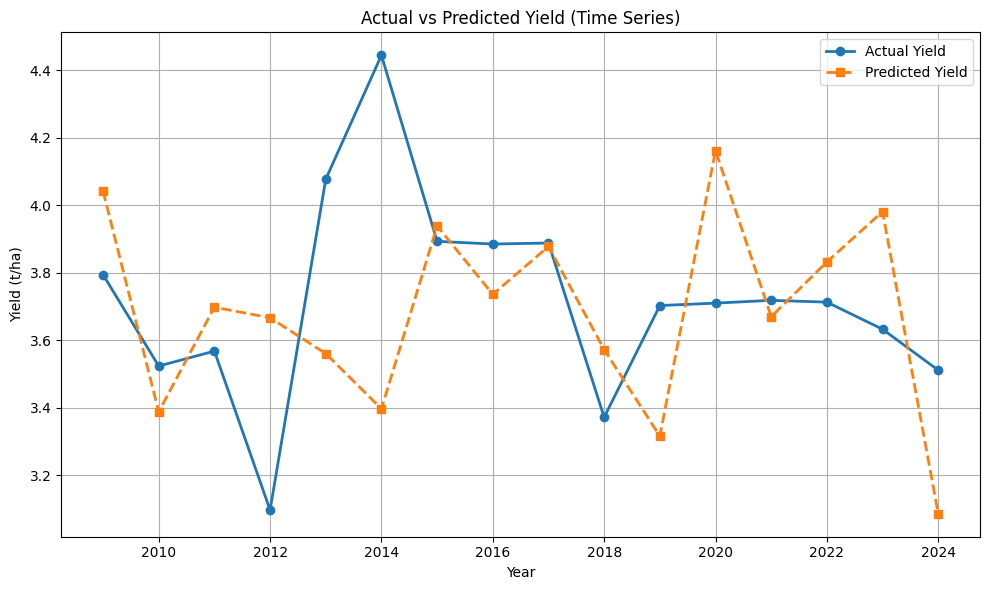

In [ ]:


# Assuming y_trues and y_preds are in the same order as df_merged['year_numeric']
years = df_merged['year_numeric'].values

plt.figure(figsize=(10, 6))
plt.plot(years, y_trues, label='Actual Yield', marker='o', linewidth=2)
plt.plot(years, y_preds, label='Predicted Yield', marker='s', linewidth=2, linestyle='--')
plt.xlabel('Year')
plt.ylabel('Yield (t/ha)')
plt.title('Actual vs Predicted Yield (Time Series)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Upto this code is generic

 Following code is hard coded

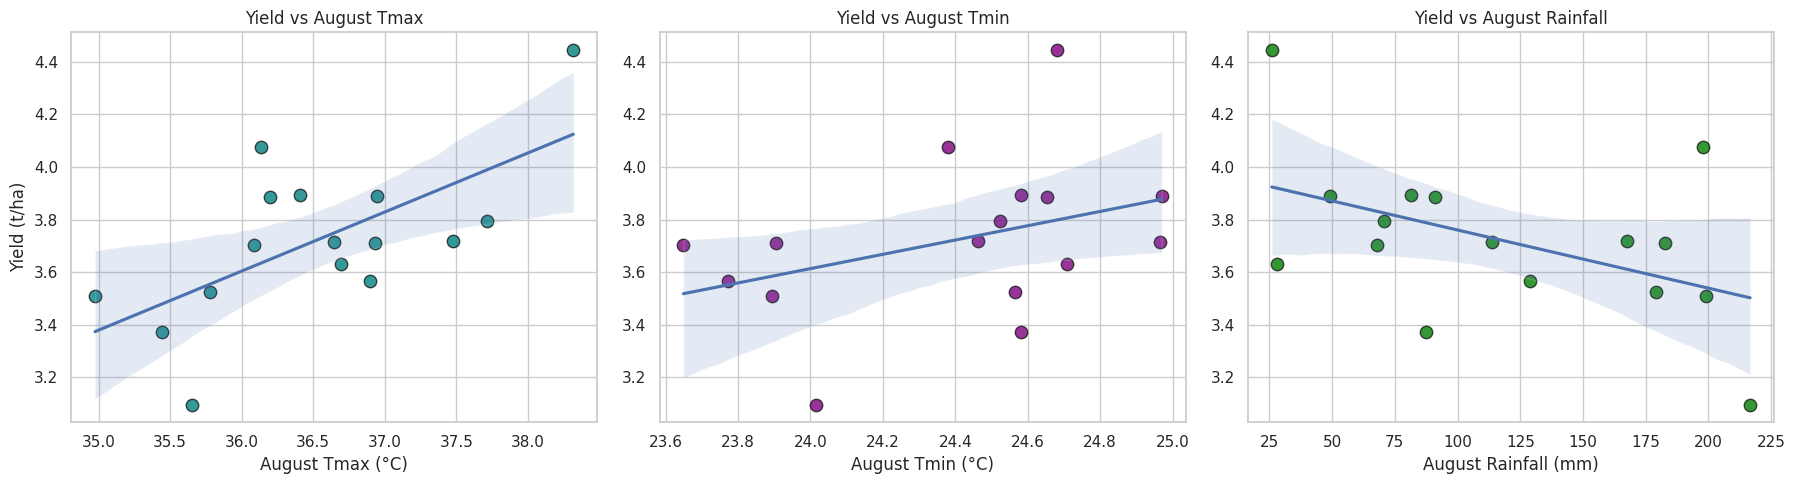

Correlation (tmax_08 vs Yield): 0.6494
Correlation (tmin_08 vs Yield): 0.3751
Correlation (rain_08 vs Yield): -0.4716


In [ ]:
# Set overall style
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: tmax_08 vs yield
sns.regplot(x=X['tmax_08'], y=y, ax=axes[0], scatter_kws={'s': 80, 'color': 'teal', 'edgecolor': 'k'})
axes[0].set_title('Yield vs August Tmax')
axes[0].set_xlabel('August Tmax (°C)')
axes[0].set_ylabel('Yield (t/ha)')

# Plot 2: tmin_08 vs yield
sns.regplot(x=X['tmin_08'], y=y, ax=axes[1], scatter_kws={'s': 80, 'color': 'purple', 'edgecolor': 'k'})
axes[1].set_title('Yield vs August Tmin')
axes[1].set_xlabel('August Tmin (°C)')
axes[1].set_ylabel('')

# Plot 3: rain_08 vs yield
sns.regplot(x=X['rain_08'], y=y, ax=axes[2], scatter_kws={'s': 80, 'color': 'green', 'edgecolor': 'k'})
axes[2].set_title('Yield vs August Rainfall')
axes[2].set_xlabel('August Rainfall (mm)')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

# Correlations
corr_tmax = X['tmax_08'].corr(y)
corr_tmin = X['tmin_08'].corr(y)
corr_rain = X['rain_08'].corr(y)

print(f"Correlation (tmax_08 vs Yield): {corr_tmax:.4f}")
print(f"Correlation (tmin_08 vs Yield): {corr_tmin:.4f}")
print(f"Correlation (rain_08 vs Yield): {corr_rain:.4f}")
